# Simulations

In [344]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from neurodsp.sim import sim_powerlaw, sim_oscillation, sim_combined, sim_synaptic_current
from neurodsp.spectral import compute_spectrum
from neurodsp.utils import create_times
from neurodsp.plts import plot_time_series, plot_power_spectra, plot_bursts
from neurodsp.utils import set_random_seed
from neurodsp.burst import detect_bursts_dual_threshold

from fooof import FOOOF
from fooof.sim import *
from fooof.sim.params import Stepper, param_iter
from fooof.utils import trim_spectrum
from fooof.plts import plot_spectrum, plot_spectra
from fooof.plts.utils import add_shades

from utils import save_fig
from settings import BANDS, BAND_COLORS

In [2]:
import seaborn as sns
sns.set_context('talk')

In [3]:
set_random_seed(505)

## Settings

In [4]:
# Simulation settings
fs = 500
n_seconds = 60

In [5]:
# Define a range of exponent values
exps = np.arange(-2.5, 0.5, 0.5)

In [6]:
times = create_times(n_seconds, fs)

In [7]:
# Notebook settings
SAVE = False

## Simulations

#### Single Oscillation

In [8]:
sig = sim_oscillation(n_seconds, fs, 10)

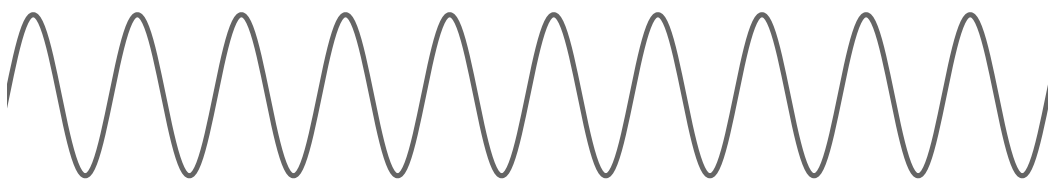

In [9]:
plot_time_series(times, sig, alpha=0.6, lw=5, xlim=[1, 2])
plt.axis('off');
plt.tight_layout()
save_fig(SAVE, 'oscillation.pdf')

#### Powerlaw

In [10]:
white = sim_powerlaw(n_seconds, fs, 0)
pink = sim_powerlaw(n_seconds, fs, -1)

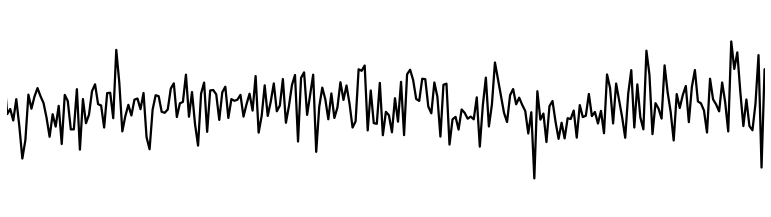

In [11]:
_, ax = plt.subplots(figsize=(12, 4))
plot_time_series(times, white, xlim=[1, 1.5], ax=ax)
plt.gca().axis('off')
save_fig(SAVE, 'white_noise_time_series.pdf')

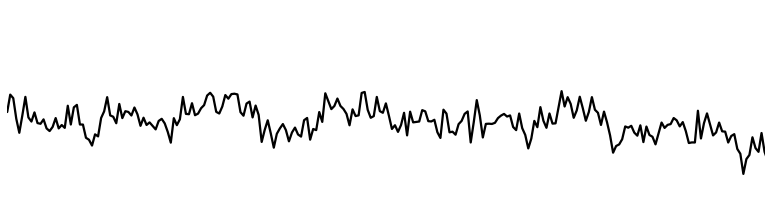

In [12]:
_, ax = plt.subplots(figsize=(12, 4))
plot_time_series(times, pink, xlim=[1, 1.5], ax=ax)
plt.gca().axis('off')
save_fig(SAVE, 'pink_noise_time_series.pdf')

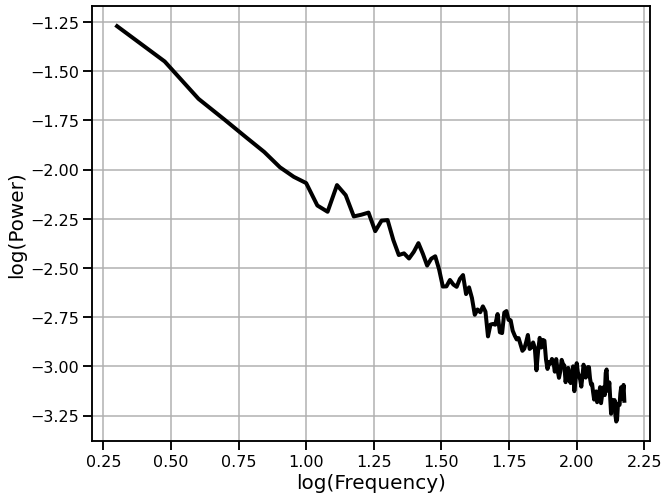

In [13]:
freqs, powers = compute_spectrum(pink, fs)
plot_spectrum(*trim_spectrum(freqs, powers, [2, 150]), 
              log_freqs=True, log_powers=True, lw=4, color='black')
save_fig(SAVE, 'pink_noise_spectrum.pdf')

#### Combined Signal

In [450]:
comps = {'sim_powerlaw' : {'exponent' : -1, 'f_range' : [1., 75]}, 
         'sim_bursty_oscillation' : {'freq' : 6, 'enter_burst' : 0.25, 'leave_burst' : 0.3}}
sig = sim_combined(n_seconds, fs, comps, [0.5, 1])

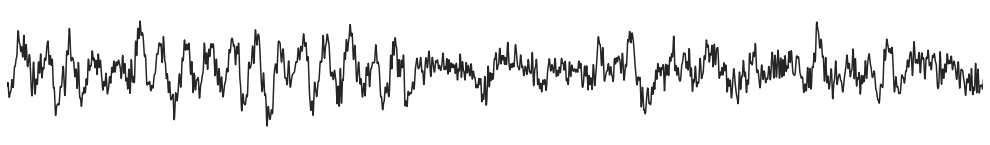

In [453]:
plot_time_series(times, sig, lw=1.5, alpha=0.85, xlim=[8, 15])
plt.gca().axis('off')
save_fig(SAVE, 'oscillation_time_series.pdf')

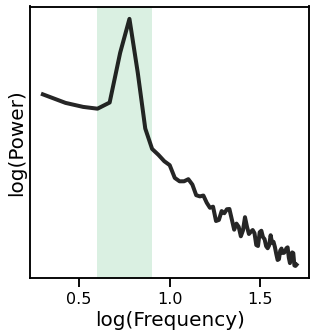

In [428]:
_, ax = plt.subplots(figsize=(5, 5))
freqs, powers = compute_spectrum(sig, fs, nperseg=1.5*fs, noverlap=fs)
plot_spectrum(*trim_spectrum(freqs, powers, [2, 50]), alpha=0.85,
              log_freqs=True, log_powers=True, lw=4, color='black', ax=ax)
add_shades(plt.gca(), [4, 8], 
           colors=BAND_COLORS['theta'], 
           #colors='#1DB100',
           logged=True)
plt.grid()
plt.yticks([])
save_fig(SAVE, 'combined_psd.pdf')

### XXX

In [429]:
bursts = detect_bursts_dual_threshold(sig, fs, (0.25, 2.), (4, 8))

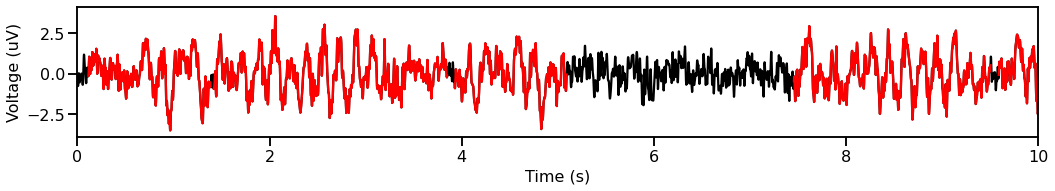

In [430]:
plot_bursts(times, sig, bursts, xlim=[0, 10])

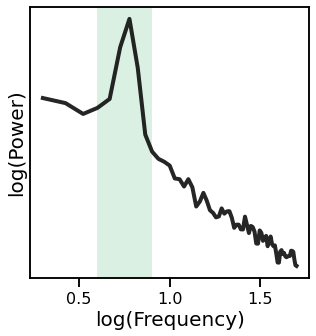

In [431]:
_, ax = plt.subplots(figsize=(5, 5))
freqs, powers = compute_spectrum(sig[bursts], fs, nperseg=1.5*fs, noverlap=fs)
plot_spectrum(*trim_spectrum(freqs, powers, [2, 50]), alpha=0.85,
              log_freqs=True, log_powers=True, lw=4, color='black', ax=ax)
add_shades(plt.gca(), [4, 8], 
           colors=BAND_COLORS['theta'], 
           #colors='#1DB100',
           logged=True)
plt.grid()
plt.yticks([])
save_fig(SAVE, 'combined_burst_psd.pdf')

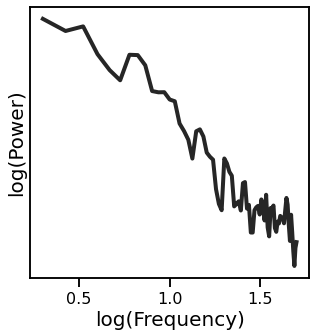

In [432]:
_, ax = plt.subplots(figsize=(5, 5))
freqs, powers = compute_spectrum(sig[~bursts], fs, nperseg=1.5*fs, noverlap=fs)
plot_spectrum(*trim_spectrum(freqs, powers, [2, 50]), alpha=0.85,
              log_freqs=True, log_powers=True, lw=4, color='black', ax=ax)
plt.grid()
plt.yticks([])
save_fig(SAVE, 'combined_nonburst_psd.pdf')

#### Synaptic Signal

In [433]:
sig = sim_synaptic_current(n_seconds, fs)

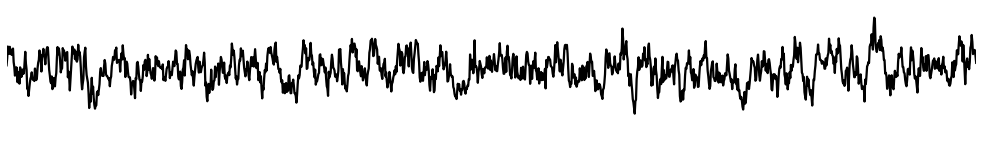

In [434]:
plot_time_series(times, sig, xlim=[10, 13])
plt.gca().axis('off')
save_fig(SAVE, 'synaptic_time_series.pdf')

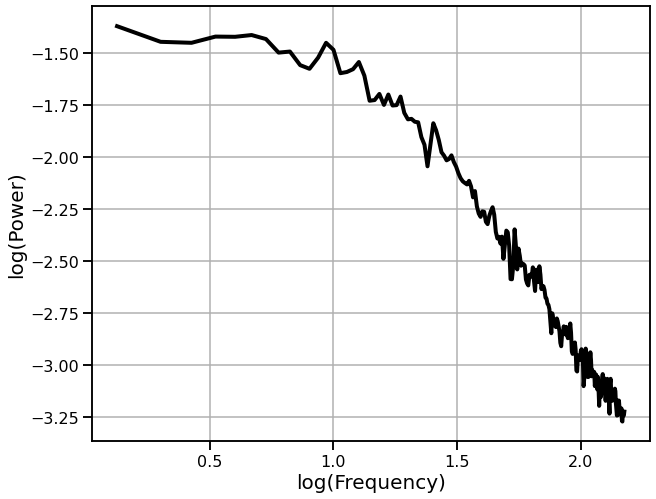

In [435]:
freqs, powers = compute_spectrum(sig, fs, nperseg=1.5*fs, noverlap=fs)
plot_spectrum(*trim_spectrum(freqs, powers, [1, 150]),
              log_freqs=True, log_powers=True, lw=4, color='black')
save_fig(SAVE, 'synaptic_theta_spectrum.pdf')

#### Combined Synaptic Signal

In [436]:
comps = {'sim_synaptic_current' : {}, 
         'sim_bursty_oscillation' : {'freq' : 6}}
sig = sim_combined(n_seconds, fs, comps, [0.75, 1])

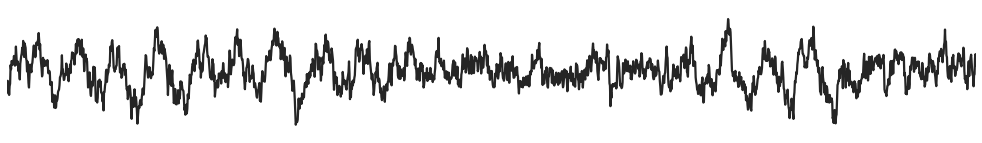

In [441]:
plot_time_series(times, sig, xlim=[10, 14], alpha=0.85)
plt.gca().axis('off')
save_fig(True, 'synaptic_theta_time_series.pdf')

In [443]:
BAND_COLORS['theta']

'#46b870'

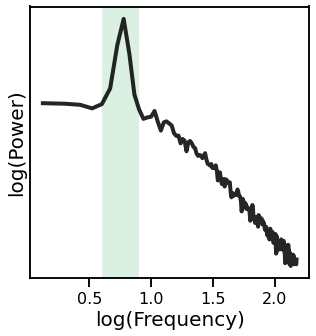

In [440]:
_, ax = plt.subplots(figsize=(5, 5))
freqs, powers = compute_spectrum(sig, fs, nperseg=1.5*fs, noverlap=fs)
plot_spectrum(*trim_spectrum(freqs, powers, [1, 150]), alpha=0.85,
              log_freqs=True, log_powers=True, lw=4, color='black', ax=ax)
plt.grid()
plt.yticks([])
add_shades(plt.gca(), [4, 8], 
           colors=BAND_COLORS['theta'], 
           #colors='#1DB100',
           logged=True)
save_fig(SAVE, 'synaptic_theta_spectrum.pdf')

## Multiple Signals

#### Multiple Powerlaw

In [24]:
sigs = []
for exp in exps:
    sigs.append(sim_powerlaw(n_seconds, fs, exp, f_range=[0.5, None]))

In [25]:
cmap = [plt.cm.gist_heat(ind) for ind in np.linspace(0, 1, len(exps) + 2)]

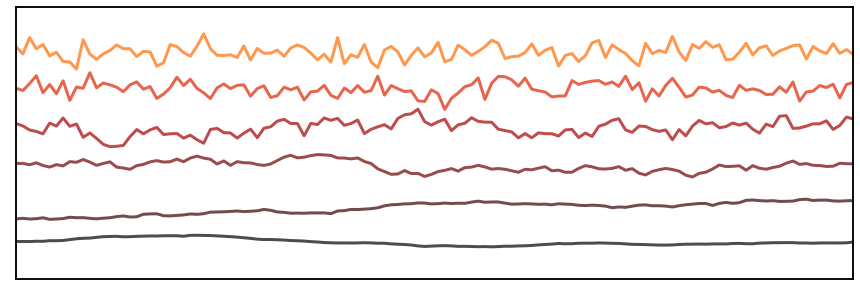

In [26]:
_, ax = plt.subplots(figsize=(15, 5))
for ind, sig in enumerate(sigs):
    ax.plot(times, sig+5*ind, color=cmap[ind], alpha=0.7, lw=3.)
ax.set_xlim([0, 0.25])
ax.set(xticks=[], yticks=[]);
save_fig(SAVE, 'multi_noise_time_series.pdf')

In [27]:
# Compute power spectra for the powerlaw signals 
all_powers = []
for ind, sig in enumerate(sigs):
    freqs, cur_powers = compute_spectrum(sig, fs, nperseg=5*fs, noverlap=fs)
    freqs, cur_powers = trim_spectrum(freqs, cur_powers, [1, 50])    
    all_powers.append(cur_powers / cur_powers[0])

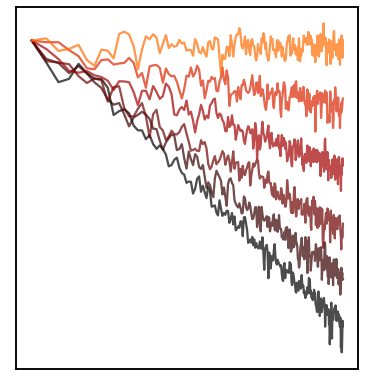

In [28]:
# Plot power spectra of different noise colours
#plot_spectra(freqs, all_powers, log_freqs=True, log_powers=True, lw=3, alpha=0.75)
plot_power_spectra(freqs, all_powers, colors=cmap, alpha=0.7, xlabel=None, ylabel=None)
plt.xticks([])
plt.yticks([])
plt.minorticks_off()
save_fig(SAVE, 'multi_noise_psd.pdf')

### Multiple Spectra

In [29]:
# Define 
FREQ_RANGE = [2, 30]
EXP_DEF = [0, 0.75]

# The Stepper object iterates through a range of values
pw_step = Stepper(0, 0.5, 0.05)
num_spectra = len(pw_step)

# `param_iter` creates a generator can be used to step across ranges of parameters
pw_iter = param_iter([10, pw_step, 1])

# Simulate power spectra
pw_fs, pw_ps = gen_group_power_spectra(num_spectra, FREQ_RANGE, EXP_DEF, pw_iter, nlvs=0.01)

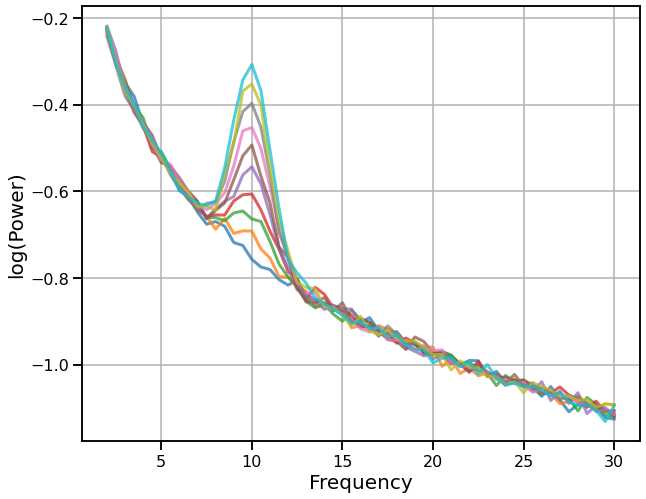

In [30]:
# Plot our series of generated power spectra, with varying high-band power
plot_spectra(pw_fs, pw_ps, log_powers=True, lw=3, alpha=0.75)
save_fig(SAVE, 'alphas.pdf')